# Mexican economic indicators

> By Elias Castellanos Alamilla

The main goal is to get the require data to create our personal local database (mySQL), that will help to develop a data analyst project that helps to understand the mexican economic health through statistic's and ML.

## Data gathering

- We are going to apply web scraping as possible to get the target features to develop this case study.
- If not, we're gonna use the excel file from the main source (official web sites).

### Target data
* MME (mexican oil price usd)
* mexican currency (pesos mx)
* annual inflation(%)
* interbank interest rate (%)
* CETES (%)
* UDIS (pesos mx)
* [GDP](https://datos.bancomundial.org/indicator/NY.GDP.MKTP.KD.ZG?end=2021&locations=MX&start=1961&view=chart) (%)
* [Mexican production rates](https://sih.hidrocarburos.gob.mx/) (oil & gas)
* latitude and longitude [Shapefiles CNH](https://mapa.hidrocarburos.gob.mx/) (oil wells mapping)

### Extra info
* [Tutorial](https://www.youtube.com/watch?v=hX4zcElR7RE&ab_channel=PyPro-GuillermoIzquierdo)
* [Token Banxico](https://www.banxico.org.mx/SieAPIRest/service/v1/)
* [Series Id's](https://www.banxico.org.mx/SieAPIRest/service/v1/doc/catalogoSeries)

In [1]:
# Data manipulation
from sqlalchemy import create_engine, text
import mysql.connector
from geopandas import GeoDataFrame
import geopandas as gpd
import pandas as pd

# Web Scraping
import requests

# Maths/basic statistics
import numpy as np 

# Data viz
import matplotlib.pyplot as plt

# Datetime
from datetime import datetime

# OS
import os
import random

# import local notebooks as python functions
import import_ipynb

In [2]:
# Import local functions

# Web Scraping
from my_functions import download_bmx_timeseries, get_mme_prices, download_production_rates

# Data manipulation
from my_functions import send_sql_data, compare_and_aggregate, zip_2_df

importing Jupyter notebook from my_functions.ipynb


In [3]:
# Create local directories
if not os.path.exists('./data'):
    os.mkdir('./data')
    
if not os.path.exists('./viz'):
    os.mkdir('./viz')

In [4]:
# Token to acces Banxico API
token = 'ce14029bd82ef17514d8faee92ee5beed62e31a15e86366bdefee64c2570b875'
print(f"Token lenght: {len(token)}")

Token lenght: 64


In [5]:
# Define MySQL database connection details
db_connection = {
    'host': '127.0.0.1',
    'user': 'mrrobot',
    'password': 'esto es una base de datos relacional',
    'db': 'mei',
}

In [6]:
# "Only for first-time run, this create the schema to store our data as SQL table's"

dbname = 'mei'

eng = create_engine(f"mysql+pymysql://{db_connection['user']}:{db_connection['password']}@{db_connection['host']}/{db_connection['db']}")

# mydb = mysql.connector.connect(
#     host=db_connection['host'], 
#     user=db_connection['user'],
#     password=db_connection['password'])

# mycursor = mydb.cursor()

# # mei stands for mexican economic indicators
# mycursor.execute(f"CREATE SCHEMA {dbname};")

Precio de adquisición en pesos para 1 dólar
https://www.banxico.org.mx/SieAPIRest/service/v1/series/SF63528/datos/1990-01-01/2023-06-01


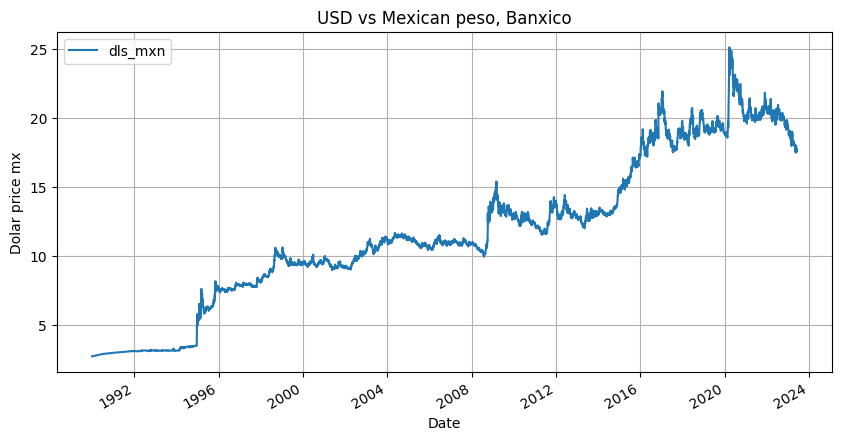

In [7]:
# https://www.banxico.org.mx/SieAPIRest/service/v1/doc/consultaDatosSerieOp
print("Precio de adquisición en pesos para 1 dólar")

dolares_bmx = download_bmx_timeseries(token, 'SF63528', '1990-01-01')
dolares_bmx.rename(columns={'dato':'dls_mxn'}, inplace=True)
dolares_bmx.plot(figsize=(10, 5), 
                 grid=True, 
                 xlabel='Date', ylabel='Dolar price mx', title='USD vs Mexican peso, Banxico'
                )

plt.show()

In [8]:
dolares_bmx.head()

,dls_mxn
fecha,
1990-01-02,2.6865
1990-01-03,2.6875
1990-01-04,2.6905
1990-01-05,2.6915
1990-01-08,2.6925


In [9]:
dolares_bmx.tail()

,dls_mxn
fecha,
2023-05-26,17.6723
2023-05-29,17.5605
2023-05-30,17.6532
2023-05-31,17.7418
2023-06-01,17.5673


In [10]:
dolares_bmx.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8396 entries, 1990-01-02 to 2023-06-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dls_mxn  8396 non-null   float64
dtypes: float64(1)
memory usage: 131.2 KB


In [11]:
table_name='dls_mx'

send_sql_data(
    db_connection,
    dolares_bmx, 
    table_name
)

Error sending data to SQL: Table 'dls_mx' already exists.


In [12]:
# Define SQL query to retrieve database data
db_data_query = f"SELECT * FROM {table_name}" 
local_data = dolares_bmx.reset_index()

compare_and_aggregate(local_data, db_data_query, db_connection, table_name)

No new data to add to MySQL table.


https://www.banxico.org.mx/SieAPIRest/service/v1/series/SP68257/datos/1990-01-01/2023-06-01


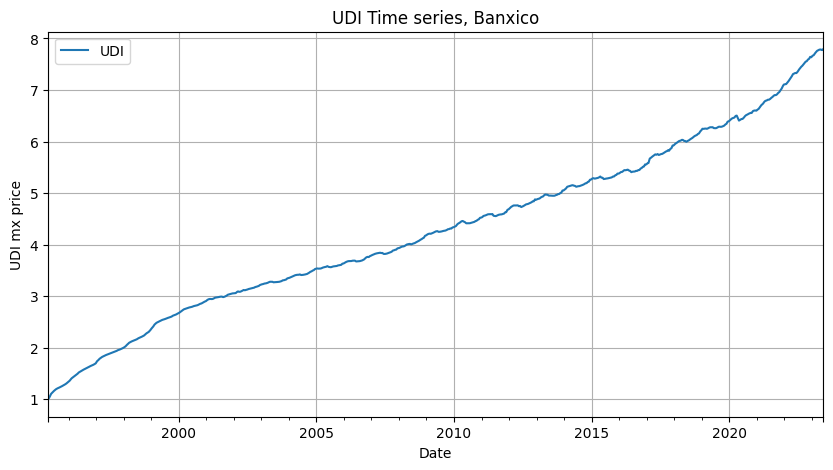

In [13]:
# print("Unidad de Inversión (UDI)")
udis_bmx = download_bmx_timeseries(token, 'SP68257', '1990-01-01')
udis_bmx.rename(columns={'dato':'UDI'}, inplace=True)
udis_bmx.plot(figsize=(10, 5), 
              grid=True, 
              xlabel='Date', ylabel='UDI mx price', title='UDI Time series, Banxico')

plt.show()

In [14]:
udis_bmx.head()

,UDI
fecha,
1995-04-04,1.000000
1995-04-05,1.001918
1995-04-06,1.003840
1995-04-07,1.005766
1995-04-08,1.007695


In [15]:
udis_bmx.tail()

,UDI
fecha,
2023-05-28,7.786964
2023-05-29,7.785417
2023-05-30,7.783869
2023-05-31,7.782322
2023-06-01,7.780776


In [16]:
udis_bmx.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10286 entries, 1995-04-04 to 2023-06-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   UDI     10286 non-null  float64
dtypes: float64(1)
memory usage: 160.7 KB


In [17]:
# Send data to mysql database
table_name='udis'

send_sql_data(
    db_connection,
    udis_bmx, 
    table_name
)

Error sending data to SQL: Table 'udis' already exists.


In [18]:
# Define SQL query to retrieve database data
db_data_query = f"SELECT * FROM {table_name}" 
local_data = udis_bmx.reset_index()

compare_and_aggregate(local_data, db_data_query, db_connection, table_name)

No new data to add to MySQL table.


https://www.banxico.org.mx/SieAPIRest/service/v1/series/SF282/datos/1990-01-01/2023-06-01


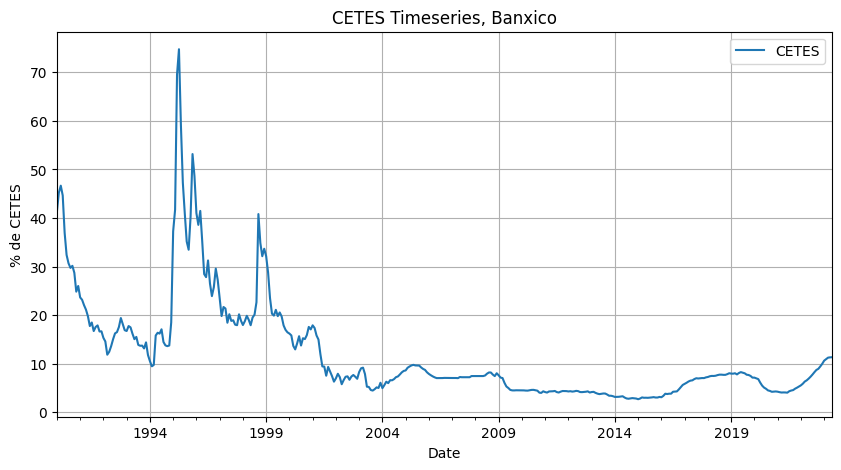

In [19]:
cetes_bmx = download_bmx_timeseries(token,'SF282', '1990-01-01')
cetes_bmx.rename(columns={'dato':'CETES'}, inplace=True)
cetes_bmx.plot(figsize=(10, 5), 
               grid=True, 
               xlabel='Date', ylabel='% de CETES', title='CETES Timeseries, Banxico')

plt.show()

In [20]:
cetes_bmx.head()

,CETES
fecha,
1990-01-01,41.29
1990-02-01,45.20
1990-03-01,46.65
1990-04-01,44.64
1990-05-01,36.92


In [21]:
cetes_bmx.tail()

,CETES
fecha,
2023-01-01,10.61
2023-02-01,10.92
2023-03-01,11.23
2023-04-01,11.29
2023-05-01,11.32


In [22]:
cetes_bmx.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 401 entries, 1990-01-01 to 2023-05-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CETES   401 non-null    float64
dtypes: float64(1)
memory usage: 6.3 KB


In [23]:
# Send data to mysql database
table_name='cetes'

send_sql_data(
    db_connection,
    cetes_bmx, 
    table_name
)

Error sending data to SQL: Table 'cetes' already exists.


In [24]:
# Define SQL query to retrieve database data
db_data_query = f"SELECT * FROM {table_name}" 
local_data = cetes_bmx.reset_index()

compare_and_aggregate(local_data, db_data_query, db_connection, table_name)

No new data to add to MySQL table.


https://www.banxico.org.mx/SieAPIRest/service/v1/series/SP30578/datos/1990-01-01/2023-06-01


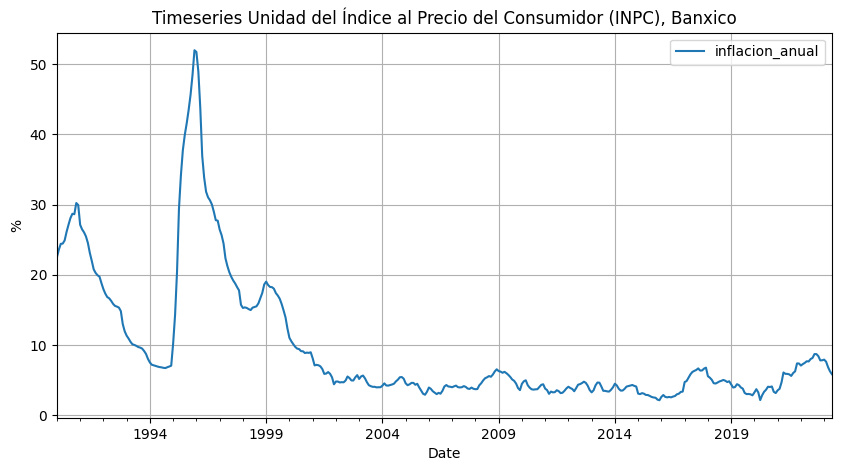

In [25]:
INPC_inflacion_anual = download_bmx_timeseries(token, 'SP30578', '1990-01-01')
INPC_inflacion_anual.rename(columns={'dato':'inflacion_anual'}, inplace=True)
INPC_inflacion_anual.plot(figsize=(10, 5), 
                          grid=True, 
                          xlabel='Date', ylabel='%', 
                          title='Timeseries Unidad del Índice al Precio del Consumidor (INPC), Banxico')

plt.show()

In [26]:
INPC_inflacion_anual.head()

,inflacion_anual
fecha,
1990-01-01,22.48
1990-02-01,23.57
1990-03-01,24.40
1990-04-01,24.43
1990-05-01,24.89


In [27]:
INPC_inflacion_anual.tail()

,inflacion_anual
fecha,
2023-01-01,7.91
2023-02-01,7.62
2023-03-01,6.85
2023-04-01,6.25
2023-05-01,5.84


In [28]:
INPC_inflacion_anual.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 401 entries, 1990-01-01 to 2023-05-01
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   inflacion_anual  401 non-null    float64
dtypes: float64(1)
memory usage: 6.3 KB


In [29]:
# Send data to mysql database
table_name = 'inflacion_anual_mx'

send_sql_data(
    db_connection, 
    INPC_inflacion_anual, 
    table_name
)

Error sending data to SQL: Table 'inflacion_anual_mx' already exists.


In [30]:
# Define SQL query to retrieve database data
db_data_query = f"SELECT * FROM {table_name}" 
local_data = INPC_inflacion_anual.reset_index()

compare_and_aggregate(local_data, db_data_query, db_connection, table_name)

No new data to add to MySQL table.


https://www.banxico.org.mx/SieAPIRest/service/v1/series/SF43783/datos/1990-01-01/2023-06-01


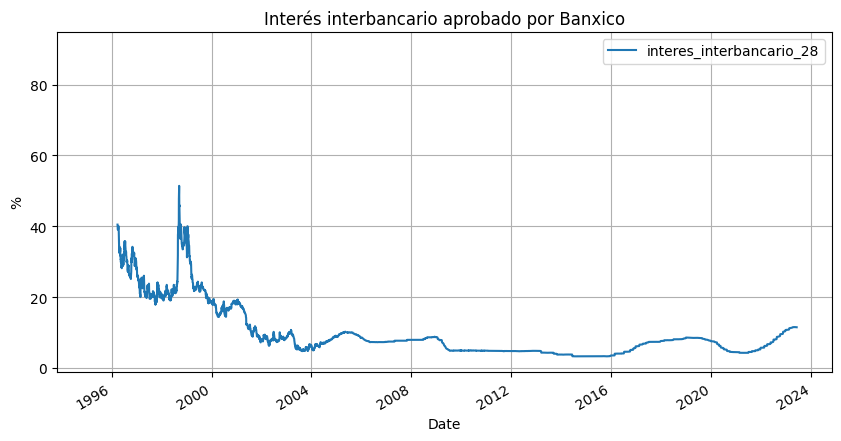

In [31]:
# Tasas de interés interbancario a 28 días por Banxico, id_serie = SF43783
iit = download_bmx_timeseries(token, 'SF43783', '1990-01-01')
iit.rename(columns={'dato':'interes_interbancario_28'}, inplace=True)
iit.plot(figsize=(10, 5), grid=True, xlabel='Date', ylabel='%', title='Interés interbancario aprobado por Banxico')

plt.show()

In [32]:
iit.head()

,interes_interbancario_28
fecha,
1995-03-23,90.5
1995-03-24,NaN
1995-03-27,NaN
1995-03-28,NaN
1995-03-29,NaN


In [33]:
iit.tail()

,interes_interbancario_28
fecha,
2023-05-26,11.5135
2023-05-29,11.5017
2023-05-30,11.5090
2023-05-31,11.5057
2023-06-01,11.4966


In [34]:
iit.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7091 entries, 1995-03-23 to 2023-06-01
Data columns (total 1 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   interes_interbancario_28  6891 non-null   float64
dtypes: float64(1)
memory usage: 110.8 KB


In [35]:
# Send data to mysql database
table_name = 'interes_interbancariomx_28'

send_sql_data(
    db_connection, 
    iit, 
    table_name
)

Error sending data to SQL: Table 'interes_interbancariomx_28' already exists.


In [36]:
# Define SQL query to retrieve database data
db_data_query = f"SELECT * FROM {table_name}"
local_data = iit.reset_index()

compare_and_aggregate(local_data, db_data_query, db_connection, table_name)

No new data to add to MySQL table.


In [37]:
mme = get_mme_prices()

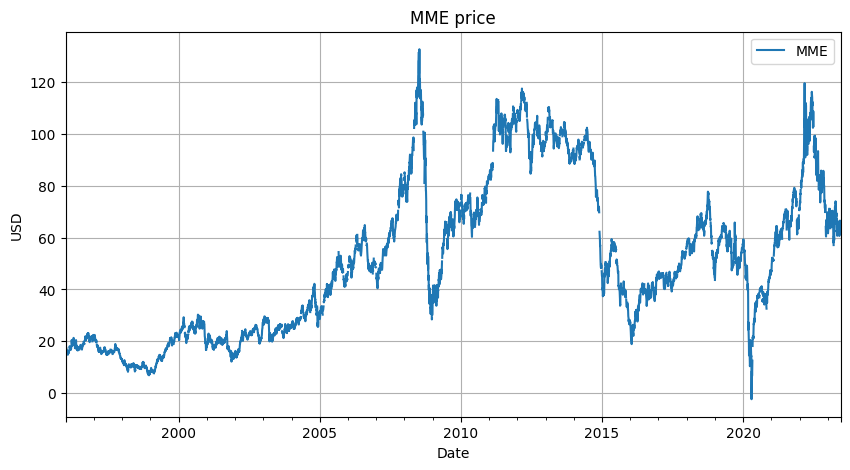

In [38]:
mme.plot(figsize=(10, 5), grid=True, xlabel='Date', ylabel='USD', title='MME price')
plt.show()

In [39]:
mme.head()

,MME
fecha,
1996-01-01,NaN
1996-01-02,NaN
1996-01-03,17.40
1996-01-04,17.41
1996-01-05,17.70


In [40]:
mme.tail()

,MME
fecha,
2023-06-12,61.62
2023-06-13,63.56
2023-06-14,63.01
2023-06-15,64.90
2023-06-16,NaN


In [41]:
mme.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7165 entries, 1996-01-01 to 2023-06-16
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   MME     6495 non-null   float64
dtypes: float64(1)
memory usage: 112.0 KB


In [42]:
# Send data to mysql database
table_name='mme'

send_sql_data(
    db_connection, 
    mme, 
    table_name
)

Error sending data to SQL: Table 'mme' already exists.


In [43]:
# Define SQL query to retrieve database data
db_data_query = f"SELECT * FROM {table_name}"
local_data = mme.fillna(method="ffill").reset_index()

compare_and_aggregate(local_data, db_data_query, db_connection, table_name)

No new data to add to MySQL table.


In [44]:
pib = pd.read_excel('./data/pib_banco_mundial.xls', header=3)
pib.drop(columns=["Country Code", "Indicator Name", "Indicator Code"], axis=1, inplace=True)
pib.head()

,Country Name,1960,1961,1962,1963,1964,1965,1966,1967,1968,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Aruba,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.035375,6.429817,-0.020479,3.543630,2.116716,5.482371,5.257856,0.635029,-18.589100,17.172509
1,NaN,NaN,0.237304,7.984460,5.163873,4.583677,5.328044,3.913909,5.255309,4.026302,...,0.770097,4.229408,4.039082,2.895728,2.485952,2.639537,2.610797,2.038299,-3.042653,4.402447
2,Afganistán,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.752287,5.600745,2.724543,1.451315,2.260314,2.647003,1.189228,3.911603,-2.351101,-20.737146
3,NaN,NaN,1.835056,3.772898,7.282985,5.392705,4.056588,-1.807283,-9.595925,1.445941,...,5.135584,6.108758,5.930450,2.745137,0.113687,2.305623,2.946175,3.190879,-0.900382,3.965399
4,Angola,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.540000,4.950000,4.820000,0.940000,-2.580000,-0.150000,-1.316312,-0.700000,-5.600000,1.100000


In [45]:
mx = pib.loc[pib["Country Name"] == "México"]
mx.reset_index(drop=True, inplace=True)
pib_mx = mx.T
pib_mx.reset_index(inplace=True)
pib_mx

,index,0
0,Country Name,México
1,1960,NaN
2,1961,5.0
3,1962,4.664415
4,1963,8.106887
...,...,...
58,2017,2.113129
59,2018,2.194995
60,2019,-0.199048
61,2020,-7.987912


In [46]:
pib_mx.drop(0, axis=0, inplace=True)
pib_mx.rename(columns={"index": "year", 0: "pib_mx"}, inplace=True)
pib_mx.set_index('year', inplace=True)
pib_mx

,pib_mx
year,
1960,NaN
1961,5.0
1962,4.664415
1963,8.106887
1964,11.905481
...,...
2017,2.113129
2018,2.194995
2019,-0.199048


In [47]:
pib_mx.reset_index(inplace=True)

In [48]:
# Send data to mysql database
send_sql_data(
    db_connection, 
    pib_mx, 
    'pib_mx'
)

Error sending data to SQL: Table 'pib_mx' already exists.


* Download selected files
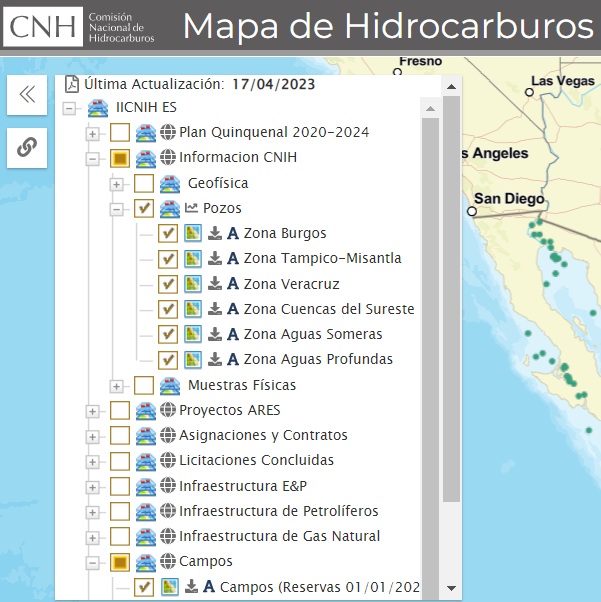

* Query and then download all files
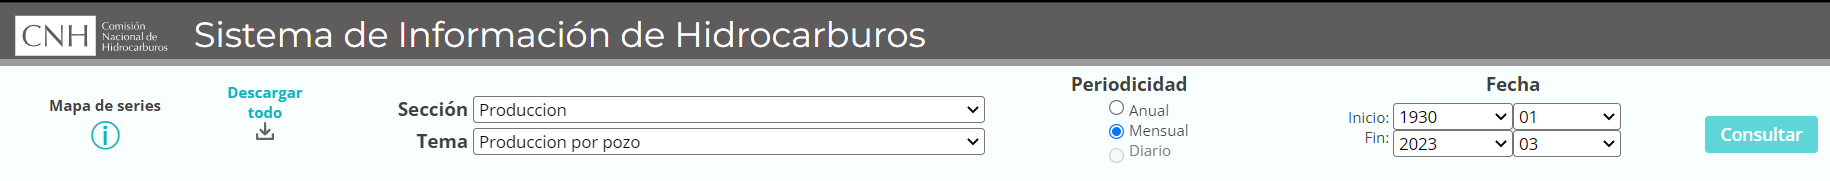

In [49]:
campo_df = gpd.read_file('./data/Campos (Reservas 01_01_2022)/Campos (Reservas 01-01-2022).shp')
a_profundas = gpd.read_file('./data/Zona Aguas Profundas/Zona Aguas Profundas.shp')
someras = gpd.read_file('./data/Zona Aguas Someras/Zona Aguas Someras.shp')
burgos = gpd.read_file('./data/Zona Burgos/Zona Burgos.shp')
sureste = gpd.read_file('./data/Zona Cuencas del Sureste/Zona Cuencas del Sureste.shp')
tm = gpd.read_file('./data/Zona Tampico-Misantla/Zona Tampico-Misantla.shp')
v = gpd.read_file('./data/Zona Veracruz/Zona Veracruz.shp')

In [50]:
all_zones = [a_profundas, someras, burgos, sureste, tm, v]
geodf_wells = GeoDataFrame(pd.concat(all_zones, ignore_index=True))
geodf_wells.head()

,pozo,campo,entidad,ubicacin,clasificac,estado_act,tipo_de_hi,fecha_inic,fecha_fin_,profundida,profundi_1,trayectori,disponible,geometry
0,LAKACH-2,LAKACH,AGUAS TERRITORIALES,AGUAS PROFUNDAS,DESARROLLO,ABANDONO TEMPORAL,GAS,20-OCT-2013,24-MAR-2014,3265.0,3265.0,VERTICAL,DISPONIBLE,POINT (-95.25447 19.02749)
1,LAKACH-52,LAKACH,AGUAS TERRITORIALES,AGUAS PROFUNDAS,DESARROLLO,ABANDONO TEMPORAL,GAS HUMEDO,26-AGO-2014,16-NOV-2014,4535.0,3243.0,DIRECCIONAL,DISPONIBLE,POINT (-95.27882 19.04477)
2,LAKACH-114,LAKACH,AGUAS TERRITORIALES,AGUAS PROFUNDAS,DESARROLLO,ABANDONO TEMPORAL,GAS HUMEDO,06-DIC-2014,23-FEB-2015,3820.0,3249.0,DIRECCIONAL,DISPONIBLE,POINT (-95.27183 19.07247)
3,LAKACH-32,LAKACH,AGUAS TERRITORIALES,AGUAS PROFUNDAS,DESARROLLO,ABANDONO TEMPORAL,GAS HUMEDO,18-JUN-2014,21-NOV-2014,3293.0,3293.0,VERTICAL,DISPONIBLE,POINT (-95.26623 19.05390)
4,LAKACH-1,LAKACH,AGUAS TERRITORIALES,AGUAS PROFUNDAS,EXPLORATORIO,ABANDONO TEMPORAL,GAS SECO,10-JUL-2006,13-NOV-2006,3813.0,3813.0,VERTICAL,DISPONIBLE,POINT (-95.25364 19.02183)


In [51]:
geodf_wells.columns

Index(['pozo', 'campo', 'entidad', 'ubicacin', 'clasificac', 'estado_act',
       'tipo_de_hi', 'fecha_inic', 'fecha_fin_', 'profundida', 'profundi_1',
       'trayectori', 'disponible', 'geometry'],
      dtype='object')

In [52]:
geodf_wells.rename(
    columns=
    {
        'ubicacin':'ubicacion', 
        'clasificac':'clasificacion', 
        'estado_act':'estatus', 
        'tipo_de_hi':'tipo_hcs', 
        'fecha_inic':'fecha_inicio', 
        'fecha_fin_':'fecha_fin', 
        'profundida':'profundidadD', 
        'profundi_1':'profundidadV', 
        'trayectori':'trayectoria'
    }, 
inplace=True
)
geodf_wells.head()

,pozo,campo,entidad,ubicacion,clasificacion,estatus,tipo_hcs,fecha_inicio,fecha_fin,profundidadD,profundidadV,trayectoria,disponible,geometry
0,LAKACH-2,LAKACH,AGUAS TERRITORIALES,AGUAS PROFUNDAS,DESARROLLO,ABANDONO TEMPORAL,GAS,20-OCT-2013,24-MAR-2014,3265.0,3265.0,VERTICAL,DISPONIBLE,POINT (-95.25447 19.02749)
1,LAKACH-52,LAKACH,AGUAS TERRITORIALES,AGUAS PROFUNDAS,DESARROLLO,ABANDONO TEMPORAL,GAS HUMEDO,26-AGO-2014,16-NOV-2014,4535.0,3243.0,DIRECCIONAL,DISPONIBLE,POINT (-95.27882 19.04477)
2,LAKACH-114,LAKACH,AGUAS TERRITORIALES,AGUAS PROFUNDAS,DESARROLLO,ABANDONO TEMPORAL,GAS HUMEDO,06-DIC-2014,23-FEB-2015,3820.0,3249.0,DIRECCIONAL,DISPONIBLE,POINT (-95.27183 19.07247)
3,LAKACH-32,LAKACH,AGUAS TERRITORIALES,AGUAS PROFUNDAS,DESARROLLO,ABANDONO TEMPORAL,GAS HUMEDO,18-JUN-2014,21-NOV-2014,3293.0,3293.0,VERTICAL,DISPONIBLE,POINT (-95.26623 19.05390)
4,LAKACH-1,LAKACH,AGUAS TERRITORIALES,AGUAS PROFUNDAS,EXPLORATORIO,ABANDONO TEMPORAL,GAS SECO,10-JUL-2006,13-NOV-2006,3813.0,3813.0,VERTICAL,DISPONIBLE,POINT (-95.25364 19.02183)


In [53]:
geodf_wells.tail()

,pozo,campo,entidad,ubicacion,clasificacion,estatus,tipo_hcs,fecha_inicio,fecha_fin,profundidadD,profundidadV,trayectoria,disponible,geometry
33872,COCUITE-416,COCUITE,VERACRUZ DE IGNACIO DE LA LLAVE,TERRESTRE,DESARROLLO,INACTIVO,GAS,23-SEP-2002,04-NOV-2002,3069.0,2837.7,DIRECCIONAL,DISPONIBLE,POINT (-96.00667 18.63981)
33873,CAUCHY-191,CAUCHY,VERACRUZ DE IGNACIO DE LA LLAVE,TERRESTRE,DESARROLLO,PRODUCTOR,GAS,14-ENE-2010,09-FEB-2010,3366.0,1959.7,DIRECCIONAL,DISPONIBLE,POINT (-95.73586 18.11375)
33874,TLACOTALPAN-1,NO DISPONIBLE,VERACRUZ DE IGNACIO DE LA LLAVE,TERRESTRE,EXPLORATORIO,CERRADO,NaN,19-ABR-1959,12-AGO-1959,2441.0,2441.0,VERTICAL,DISPONIBLE,POINT (-95.60817 18.54614)
33875,PERDIZ-509,PERDIZ,VERACRUZ DE IGNACIO DE LA LLAVE,TERRESTRE,DESARROLLO,INACTIVO,ACEITE,07-ABR-2009,09-JUN-2009,3172.0,3041.0,DIRECCIONAL,DISPONIBLE,POINT (-96.12033 18.52003)
33876,GUINEA-1,PERDIZ,VERACRUZ DE IGNACIO DE LA LLAVE,TERRESTRE,EXPLORATORIO,CERRADO,NaN,27-ENE-2001,18-AGO-2001,3750.0,3750.0,VERTICAL,DISPONIBLE,POINT (-96.15755 18.52468)


In [54]:
geodf_wells = geodf_wells.to_crs(crs=4326)
geodf_wells['lon'] = geodf_wells.centroid.x
geodf_wells['lat'] = geodf_wells.centroid.y

C:\Users\ecast\AppData\Local\Temp\ipykernel_11816\4092001676.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geodf_wells['lon'] = geodf_wells.centroid.x
C:\Users\ecast\AppData\Local\Temp\ipykernel_11816\4092001676.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geodf_wells['lat'] = geodf_wells.centroid.y


In [55]:
geodf_wells[['lat', 'lon']].head()

,lat,lon
0,19.027488,-95.254471
1,19.044774,-95.278819
2,19.072467,-95.271832
3,19.053898,-95.266226
4,19.021830,-95.253636


In [56]:
# Convert to dataframe
df = pd.DataFrame(geodf_wells)
df.head()

,pozo,campo,entidad,ubicacion,clasificacion,estatus,tipo_hcs,fecha_inicio,fecha_fin,profundidadD,profundidadV,trayectoria,disponible,geometry,lon,lat
0,LAKACH-2,LAKACH,AGUAS TERRITORIALES,AGUAS PROFUNDAS,DESARROLLO,ABANDONO TEMPORAL,GAS,20-OCT-2013,24-MAR-2014,3265.0,3265.0,VERTICAL,DISPONIBLE,POINT (-95.25447 19.02749),-95.254471,19.027488
1,LAKACH-52,LAKACH,AGUAS TERRITORIALES,AGUAS PROFUNDAS,DESARROLLO,ABANDONO TEMPORAL,GAS HUMEDO,26-AGO-2014,16-NOV-2014,4535.0,3243.0,DIRECCIONAL,DISPONIBLE,POINT (-95.27882 19.04477),-95.278819,19.044774
2,LAKACH-114,LAKACH,AGUAS TERRITORIALES,AGUAS PROFUNDAS,DESARROLLO,ABANDONO TEMPORAL,GAS HUMEDO,06-DIC-2014,23-FEB-2015,3820.0,3249.0,DIRECCIONAL,DISPONIBLE,POINT (-95.27183 19.07247),-95.271832,19.072467
3,LAKACH-32,LAKACH,AGUAS TERRITORIALES,AGUAS PROFUNDAS,DESARROLLO,ABANDONO TEMPORAL,GAS HUMEDO,18-JUN-2014,21-NOV-2014,3293.0,3293.0,VERTICAL,DISPONIBLE,POINT (-95.26623 19.05390),-95.266226,19.053898
4,LAKACH-1,LAKACH,AGUAS TERRITORIALES,AGUAS PROFUNDAS,EXPLORATORIO,ABANDONO TEMPORAL,GAS SECO,10-JUL-2006,13-NOV-2006,3813.0,3813.0,VERTICAL,DISPONIBLE,POINT (-95.25364 19.02183),-95.253636,19.021830


In [57]:
# Change month language
df["fecha_inicio"] = df["fecha_inicio"].str.replace("ENE", "JAN")
df["fecha_inicio"] = df["fecha_inicio"].str.replace("ABR", "APR")
df["fecha_inicio"] = df["fecha_inicio"].str.replace("AGO", "AUG")
df["fecha_inicio"] = df["fecha_inicio"].str.replace("DIC", "DEC")
df["fecha_fin"] = df["fecha_fin"].str.replace("ENE", "JAN")
df["fecha_fin"] = df["fecha_fin"].str.replace("ABR", "APR")
df["fecha_fin"] = df["fecha_fin"].str.replace("AGO", "AUG")
df["fecha_fin"] = df["fecha_fin"].str.replace("DIC", "DEC")

In [58]:
df.dropna(subset=["fecha_inicio", "fecha_fin"], axis=0, inplace=True)

In [60]:
dates = df[["fecha_inicio", "fecha_fin"]]

In [61]:
# Pandas series with dates
fechas = list(dates["fecha_inicio"])
fechas_fin = list(dates["fecha_fin"])

# empty list
dates_init = []
dates_end = []

for i in range(len(fechas)):
    date = datetime.strptime(fechas[i], '%d-%b-%Y')
    i+=1
    dates_init.append(date)
    
for j in range(len(fechas_fin)):
    date_end = datetime.strptime(fechas_fin[j], '%d-%b-%Y')
    j+=1
    dates_end.append(date_end)

In [62]:
today = datetime.today()
df["fecha_inicio"] = dates_init
df["fecha_fin"] = dates_end
df["tiempo_operacion"] = df.fecha_fin - df.fecha_inicio
df["tiempo_operacion"] = df.tiempo_operacion.dt.days
df["edad"] = round((today - df.fecha_fin) / np.timedelta64(1, 'Y'), 2)

df.head()

,pozo,campo,entidad,ubicacion,clasificacion,estatus,tipo_hcs,fecha_inicio,fecha_fin,profundidadD,profundidadV,trayectoria,disponible,geometry,lon,lat,tiempo_operacion,edad
0,LAKACH-2,LAKACH,AGUAS TERRITORIALES,AGUAS PROFUNDAS,DESARROLLO,ABANDONO TEMPORAL,GAS,2013-10-20,2014-03-24,3265.0,3265.0,VERTICAL,DISPONIBLE,POINT (-95.25447 19.02749),-95.254471,19.027488,155,9.24
1,LAKACH-52,LAKACH,AGUAS TERRITORIALES,AGUAS PROFUNDAS,DESARROLLO,ABANDONO TEMPORAL,GAS HUMEDO,2014-08-26,2014-11-16,4535.0,3243.0,DIRECCIONAL,DISPONIBLE,POINT (-95.27882 19.04477),-95.278819,19.044774,82,8.60
2,LAKACH-114,LAKACH,AGUAS TERRITORIALES,AGUAS PROFUNDAS,DESARROLLO,ABANDONO TEMPORAL,GAS HUMEDO,2014-12-06,2015-02-23,3820.0,3249.0,DIRECCIONAL,DISPONIBLE,POINT (-95.27183 19.07247),-95.271832,19.072467,79,8.32
3,LAKACH-32,LAKACH,AGUAS TERRITORIALES,AGUAS PROFUNDAS,DESARROLLO,ABANDONO TEMPORAL,GAS HUMEDO,2014-06-18,2014-11-21,3293.0,3293.0,VERTICAL,DISPONIBLE,POINT (-95.26623 19.05390),-95.266226,19.053898,156,8.58
4,LAKACH-1,LAKACH,AGUAS TERRITORIALES,AGUAS PROFUNDAS,EXPLORATORIO,ABANDONO TEMPORAL,GAS SECO,2006-07-10,2006-11-13,3813.0,3813.0,VERTICAL,DISPONIBLE,POINT (-95.25364 19.02183),-95.253636,19.021830,126,16.60


In [63]:
# Send data to mysql database
table_name='mx_wells_coordinates'

send_sql_data(
    db_connection, 
    df, 
    table_name
)

Error sending data to SQL: Table 'mx_wells_coordinates' already exists.


In [64]:
download_production_rates()

Download at...14:38:34 (21/06/2023)


In [65]:
historico_produccion = zip_2_df()
historico_produccion.head()

,Fecha,Cuenca,Asignación_o_Contrato,Nombre_del_pozo,Hidrocarburos_Liquidos_(Mbd),Petróleo_(Mbd),Condensado_(Mbd),Gas_asociado_(MMpcd),Gas_no_asociado_(MMpcd),Agua_(Mbd)
0,01-06-1930,TAMPICO-MISANTLA,NaN,POZA RICA-2,0.009015,0.009015,0.0,0.004180,0.0,0.0
1,01-07-1930,TAMPICO-MISANTLA,NaN,POZA RICA-2,0.020695,0.020695,0.0,0.009594,0.0,0.0
2,01-08-1930,TAMPICO-MISANTLA,NaN,POZA RICA-2,0.020695,0.020695,0.0,0.009594,0.0,0.0
3,01-09-1930,TAMPICO-MISANTLA,NaN,POZA RICA-2,0.020756,0.020756,0.0,0.009622,0.0,0.0
4,01-10-1930,TAMPICO-MISANTLA,NaN,POZA RICA-2,0.020695,0.020695,0.0,0.009594,0.0,0.0


In [66]:
historico_produccion.tail()

,Fecha,Cuenca,Asignación_o_Contrato,Nombre_del_pozo,Hidrocarburos_Liquidos_(Mbd),Petróleo_(Mbd),Condensado_(Mbd),Gas_asociado_(MMpcd),Gas_no_asociado_(MMpcd),Agua_(Mbd)
3138206,01-04-2023,BURGOS,CNH-R01-L03-A18/2015,PENA BLANCA-150,0.000000,0.000000,0.0,0.0,0.094386,0.000630
3138207,01-04-2023,BURGOS,CNH-R01-L03-A18/2015,PENA BLANCA-142,0.000000,0.000000,0.0,0.0,0.249178,0.000000
3138208,01-04-2023,BURGOS,CNH-R01-L03-A18/2015,PENA BLANCA-139,0.000000,0.000000,0.0,0.0,0.035570,0.000114
3138209,01-04-2023,BURGOS,CNH-R01-L03-A2/2015,BENAVIDES-11,0.000000,0.000000,0.0,0.0,0.063692,0.000588
3138210,01-04-2023,VERACRUZ,CNH-R02-L03-VC-03/2017,MATA VIOLIN-1,0.016325,0.016325,0.0,0.0,0.000000,0.003821


In [67]:
historico_produccion.columns

Index(['Fecha', 'Cuenca', 'Asignación_o_Contrato', 'Nombre_del_pozo',
       'Hidrocarburos_Liquidos_(Mbd)', 'Petróleo_(Mbd)', 'Condensado_(Mbd)',
       'Gas_asociado_(MMpcd)', 'Gas_no_asociado_(MMpcd)', 'Agua_(Mbd)'],
      dtype='object')

In [68]:
historico_produccion.rename(
    columns=
    {
       "Asignación_o_Contrato": "Contrato",
       "Nombre_del_pozo": "Pozo",
       "Hidrocarburos_Liquidos_(Mbd)": "Hcs_liq_Mbd",
       "Petróleo_(Mbd)": "Aceite_Mbd",
       "Condensado_(Mbd)": "Condensado_Mbd",
       "Gas_asociado_(MMpcd)": "Gas_asociado_MMpcd",
       "Gas_no_asociado_(MMpcd)": "Gas_no_asociado_MMpcd",
       "Agua_(Mbd)": "Agua_Mbd"
   },
   inplace=True
)

In [69]:
historico_produccion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3138211 entries, 0 to 3138210
Data columns (total 10 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Fecha                  object 
 1   Cuenca                 object 
 2   Contrato               object 
 3   Pozo                   object 
 4   Hcs_liq_Mbd            float64
 5   Aceite_Mbd             float64
 6   Condensado_Mbd         float64
 7   Gas_asociado_MMpcd     float64
 8   Gas_no_asociado_MMpcd  float64
 9   Agua_Mbd               float64
dtypes: float64(6), object(4)
memory usage: 239.4+ MB


In [70]:
historico_produccion["Fecha"] = pd.to_datetime(historico_produccion["Fecha"], format="%d-%m-%Y")

In [71]:
# Send data to mysql database
table_name='produccion_nacional_cnh'

send_sql_data(
    db_connection, 
    historico_produccion, 
    table_name
)

Data send succesfully!


In [ ]:
# Define SQL query to retrieve database data
db_data_query = f"SELECT * FROM {table_name}"
local_data = historico_produccion.reset_index()

compare_and_aggregate(local_data, db_data_query, db_connection, table_name)

In [73]:
campo_df.columns

Index(['nombre', 'superficie', 'ubicacin', 'volumen_or', 'volumen__1',
       'petrleo_cr', 'crudo_1p_m', 'gas_natura', 'condensado', 'volumen__2',
       'volumen__3', 'petrleo__1', 'crudo_2p_m', 'gas_natu_1', 'condensa_1',
       'volumen__4', 'volumen__5', 'petrleo__2', 'crudo_3p_m', 'gas_natu_2',
       'condensa_2', 'geometry'],
      dtype='object')

In [74]:
# Renombrando columnas
campo_df = campo_df.rename(
    columns={ 
        'ubicacin':'ubicacion', 
        'volumen_or':'v_original', 
        'volumen__1':'v_1', 
        'petrleo_cr':'petroleo_cr', 
        'crudo_1p_m':'crudo_1p', 
        'gas_natura':'gas_natural',
        'volumen__2':'v_2',
        'volumen__3':'v_3',
        'petrleo__1':'petroleo_1',
        'crudo_2p_m':'crudo_2p',
        'gas_natu_1':'gas_natural_1',
        'condensa_1':'condensado_1',
        'volumen__4':'v_4',
        'volumen__5':'v_5',
        'petrleo__2':'petroleo_2',
        'crudo_3p_m':'crudo_3p',
        'gas_natu_2':'gas_natural_2',
        'condensa_2':'condensado_2'
    }
)

In [75]:
campo_df.head()

,nombre,superficie,ubicacion,v_original,v_1,petroleo_cr,crudo_1p,gas_natural,condensado,v_2,...,crudo_2p,gas_natural_1,condensado_1,v_4,v_5,petroleo_2,crudo_3p,gas_natural_2,condensado_2,geometry
0,RABEL,4.42,Terrestre,0,63.99,0.03,0,0.16,0,0,...,0,0.16,0,0,63.99,0.03,0,0.16,0,"POLYGON ((-95.59913 18.18974, -95.59903 18.189..."
1,QUINTAL,0.58,Terrestre,0,2.4,0,0,0,0,0,...,0,0.7,0.04,0,2.86,0.23,0,1.2,0.06,"POLYGON ((-98.82421 25.97715, -98.82607 25.977..."
2,ROBULUS,9.79,Terrestre,0,9.76,0,0,0,0,0,...,0,1.16,0,0,26.89,1.61,0,9.42,0.01,"POLYGON ((-99.64649 27.54527, -99.64727 27.545..."
3,ROTALIA,3.85,Terrestre,0,7.66,0,0,0,0,0,...,0,4.5,0,0,18.07,0.85,0,4.5,0,"POLYGON ((-99.58689 27.51364, -99.58764 27.513..."
4,SANTANDER,0.61,Terrestre,0,401.11,1.03,0,8.57,0.05,0,...,0,20.97,0.12,0,428.31,3.53,0,29.49,0.17,"POLYGON ((-98.44799 25.83889, -98.44945 25.838..."


In [76]:
campo_df.tail()

,nombre,superficie,ubicacion,v_original,v_1,petroleo_cr,crudo_1p,gas_natural,condensado,v_2,...,crudo_2p,gas_natural_1,condensado_1,v_4,v_5,petroleo_2,crudo_3p,gas_natural_2,condensado_2,geometry
458,ITTA,5.22,Marino,79.81,54.09,7.44,6.89,4.61,0,147.34,...,27.64,25.34,0,149.32,101.2,54.5,48.66,48.29,0,"MULTIPOLYGON (((-93.29363 18.63426, -93.29332 ..."
459,PAKI,5.79,Marino,25.71,21.39,4.98,4.69,2.32,0.01,47.58,...,8.89,27.94,0.13,47.58,39.59,12.33,8.89,27.94,0.13,"POLYGON ((-93.54505 18.45738, -93.54494 18.457..."
460,TLAMATINI,5.71,Marino,143.19,87.88,26.58,24.27,18.59,0.08,143.19,...,24.27,18.59,0.08,163.28,100.21,48.77,44.53,34.08,0.15,"POLYGON ((-93.50413 18.47118, -93.50412 18.471..."
461,LAKACH,20.6025,Marino,0,513.08,3.14,0,20.07,0,0,...,0,20.07,0,0,513.08,15.04,0,96.11,0,"POLYGON ((-95.27193 19.10660, -95.27178 19.106..."
462,QUESQUI,61.39,Terrestre,682.98,2527.08,500.63,202.55,1435.63,1.96,761.83,...,278.27,2006.64,2.74,839.83,3107.43,766.34,308.47,2205.25,3.01,"POLYGON ((-93.63293 17.96916, -93.62614 17.964..."


In [77]:
campo_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 463 entries, 0 to 462
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   nombre         463 non-null    object  
 1   superficie     463 non-null    object  
 2   ubicacion      463 non-null    object  
 3   v_original     463 non-null    object  
 4   v_1            463 non-null    object  
 5   petroleo_cr    463 non-null    object  
 6   crudo_1p       463 non-null    object  
 7   gas_natural    463 non-null    object  
 8   condensado     463 non-null    object  
 9   v_2            463 non-null    object  
 10  v_3            463 non-null    object  
 11  petroleo_1     463 non-null    object  
 12  crudo_2p       463 non-null    object  
 13  gas_natural_1  463 non-null    object  
 14  condensado_1   463 non-null    object  
 15  v_4            463 non-null    object  
 16  v_5            463 non-null    object  
 17  petroleo_2     463 non-null

In [78]:
campo_df["v_original"] = campo_df["v_original"].astype(float)
campo_df["v_1"] = campo_df["v_1"].astype(float)
campo_df["petroleo_cr"] = campo_df["petroleo_cr"].astype(float)
campo_df["crudo_1p"] = campo_df["crudo_1p"].astype(float)
campo_df["gas_natural"] = campo_df["gas_natural"].astype(float)
campo_df["condensado"] = campo_df["condensado"].astype(float)
campo_df["v_2"] = campo_df["v_2"].astype(float)
campo_df["v_3"] = campo_df["v_3"].astype(float)
campo_df["petroleo_1"] = campo_df["petroleo_1"].astype(float)

In [79]:
campo_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 463 entries, 0 to 462
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   nombre         463 non-null    object  
 1   superficie     463 non-null    object  
 2   ubicacion      463 non-null    object  
 3   v_original     463 non-null    float64 
 4   v_1            463 non-null    float64 
 5   petroleo_cr    463 non-null    float64 
 6   crudo_1p       463 non-null    float64 
 7   gas_natural    463 non-null    float64 
 8   condensado     463 non-null    float64 
 9   v_2            463 non-null    float64 
 10  v_3            463 non-null    float64 
 11  petroleo_1     463 non-null    float64 
 12  crudo_2p       463 non-null    object  
 13  gas_natural_1  463 non-null    object  
 14  condensado_1   463 non-null    object  
 15  v_4            463 non-null    object  
 16  v_5            463 non-null    object  
 17  petroleo_2     463 non-null